# Natural Language Understanding

In this section we go through topics related to text understanding. We cover such topics like:
    
- Similarity measures
- Word Vectors
- Vector Space Model
- Type of vectorizers
- Build a vectorizer with Tensorflow.

## Similarity measures

Word does have different meanings. This makes the comparison and analysis a bit more complex.

In [1]:
from textblob import Word

w = Word("developer")

for synset, definition in zip(w.get_synsets(), w.define()):
    print(synset, definition)

Synset('developer.n.01') someone who develops real estate (especially someone who prepares a site for residential or commercial use)
Synset('developer.n.02') photographic equipment consisting of a chemical solution for developing film


## Similarity measures

There are plenty of methods to measure the similarity of strings. Two most popular Python libraries examples for such measure are shown. We compare two strings: trains and training. The SequenceMatcher class allow us to use the Gestalt pattern matching algorithm:

In [2]:
from difflib import SequenceMatcher
a = "training"
b = "trains"
print(len(a))
print(len(b))
ratio = SequenceMatcher(None, a, b).ratio()
print(ratio)

8
6
0.7142857142857143


The distance is a normalized value between 0 and 1, where 1 means identical.

A different approach is shown below. We use the Jellyfish library. There are a few methods that we can use here. One of it is the Levenshtein distance. Below the distance and normalize distance values are calculated.

In [3]:
import jellyfish
distance = jellyfish.levenshtein_distance(a,b)
print(distance)

normalized_distance = distance/max(len(a),len(b))
print(1.0-normalized_distance)

3
0.625


Some words can be more similar to each other than other. We can build a similarity matrix to check it where 1 mean equal and 0 totally different.

In [4]:
import spacy

nlp = spacy.load("en_core_web_sm")

tokens = nlp(u'king queen horse cat desk lamp')

for first_token in tokens:
    for second_token in tokens:
        print(first_token.text, second_token.text, first_token.similarity(second_token))

king king 1.0
king queen 0.3341248
king horse 0.4912617
king cat 0.5016426
king desk 0.45035654
king lamp 0.29997915
queen king 0.3341248
queen queen 1.0
queen horse 0.44166335
queen cat 0.49768373
queen desk 0.37395185
queen lamp 0.34415698
horse king 0.4912617
horse queen 0.44166335
horse horse 1.0
horse cat 0.5950091
horse desk 0.6192821
horse lamp 0.53208065
cat king 0.5016426
cat queen 0.49768373
cat horse 0.5950091
cat cat 1.0
cat desk 0.55696374
cat lamp 0.467345
desk king 0.45035654
desk queen 0.37395185
desk horse 0.6192821
desk cat 0.55696374
desk desk 1.0
desk lamp 0.51131934
lamp king 0.29997915
lamp queen 0.34415698
lamp horse 0.53208065
lamp cat 0.467345
lamp desk 0.51131934
lamp lamp 1.0


We can also compare sentences:

In [5]:
doc1 = nlp(u"Warsaw is the largest city in Poland.")
doc2 = nlp(u"Crossaint is baked in France.")
doc3 = nlp(u"An emu is a large bird.")

for doc in [doc1, doc2, doc3]:
    for other_doc in [doc1, doc2, doc3]:
        print(doc.similarity(other_doc))

1.0
0.7187545347421542
0.6463190019105479
0.7187545347421542
1.0
0.3968015688131289
0.6463190019105479
0.3968015688131289
1.0


The similarity matrix looks like following:

|       | doc1 | doc2 | doc3 |
|-------|------|------|------|
| **doc1** | 1.0  | 0.72 | 0.65 |
| **doc 2** | 0.72 | 1.0  | 0.40 |
| **doc 3** | 0.65 | 0.40 | 1.0  |

## Word Vectors

SpaCy does have already a set of words that are vectorized.

![](images/vectorized.png)

Let's take a look at the vectors that are available in spaCy using the previous example:

In [ ]:
nlp = spacy.load("en_core_web_sm")

tokens = nlp(u'king queen horse cat desk lamp')

for token in tokens:
    print(str(token)+" "+str(token.vector))

It looks that the vectors are quite long. It's easy to check the exact size of a vector:

In [6]:
len(tokens[1].vector)

384

You can play around and check the vector values for some other sentences. Let's take a look at sentence vectors of one of our previous examples:

In [7]:
len(doc1.vector)

384

### Build own vector space with word2vec

In this section we are going to implement two different word2vec algorithms. In the first case we implement a classic word2vec with the whole dictionary. In the second case we go with a negative sampling approach.

We need to read the text first:

In [3]:
import collections
import math
import random
from tempfile import gettempdir
import zipfile
import numpy as np
import tensorflow as tf

FILENAME = "datasets/text8.zip"

def read_data():
    with zipfile.ZipFile(FILENAME) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

vocabulary = read_data()
print('Data size', len(vocabulary))

vocabulary_size = 50000

Data size 17005207


Based on the whole document, we need to build the dataset:

In [9]:
def build_dataset(words, n_words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(n_words - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:  # dictionary['UNK']
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(vocabulary,
                                                            vocabulary_size)
del vocabulary
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156] ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


The next step is about batch generation.

In [10]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    if data_index + span > len(data):
        data_index = 0
    buffer.extend(data[data_index:data_index + span])
    data_index += span
    for i in range(batch_size // num_skips):
        context_words = [w for w in range(span) if w != skip_window]
        words_to_use = random.sample(context_words, num_skips)
        for j, context_word in enumerate(words_to_use):
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[context_word]
        if data_index == len(data):
            buffer[:] = data[:span]
            data_index = span
        else:
            buffer.append(data[data_index])
            data_index += 1        
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
          '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3081 originated -> 12 as
3081 originated -> 5234 anarchism
12 as -> 3081 originated
12 as -> 6 a
6 a -> 195 term
6 a -> 12 as
195 term -> 6 a
195 term -> 2 of


We need to setup some parameters.

![](images/the_live_training.png)

In [12]:
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2 
num_sampled = 64

valid_size = 16
valid_window = 100
valid_examples = np.random.choice(valid_window, valid_size, replace=False)

In the next step we are going to build our network architecture:

In [13]:
graph = tf.Graph()

with graph.as_default():

    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    with tf.device('/cpu:0'):
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    init = tf.global_variables_initializer()

Instructions for updating:
keep_dims is deprecated, use keepdims instead


And train it:

In [14]:
num_steps = 10000

with tf.Session(graph=graph) as session:
    init.run()
    print('Initialized')

    average_loss = 0
    for step in range(num_steps):
        batch_inputs, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            print('Average loss at step ', step, ': ', average_loss)
            average_loss = 0

        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = '%s %s,' % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  268.95098876953125
Nearest to first: jonas, distinctly, conde, pretended, abolitionists, imprinted, discrepancy, nexus,
Nearest to if: salim, processors, haer, ryukyu, strangely, stiff, togo, bicycling,
Nearest to most: amway, focused, liberator, vow, nineveh, gino, vicarage, pending,
Nearest to an: pillars, breton, loris, floorball, zariski, ubiquity, multipart, laplace,
Nearest to new: invert, macrophages, antoine, christological, lems, sensitive, sweat, gentle,
Nearest to will: syracuse, hybrid, genji, mean, orlogsflag, flatter, endomorphism, inquiring,
Nearest to which: twilight, asl, fianna, rik, rebranded, stifle, cannonball, providence,
Nearest to between: cheddar, trey, yes, tactician, sim, eaters, mounts, bun,
Nearest to use: ut, wingspan, grave, earthquakes, portable, trim, chromosome, occupants,
Nearest to american: lunch, hor, stoney, vesuvius, correction, kurf, ostracism, honda,
Nearest to more: fundraising, cytosol, albanians, reconq

Finally, we should draw it:

In [16]:
%matplotlib notebook

def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(25, 25))
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
    plt.show()

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a dimensionality reduction method.

![](images/tsne.png)


<IPython.core.display.Javascript object>


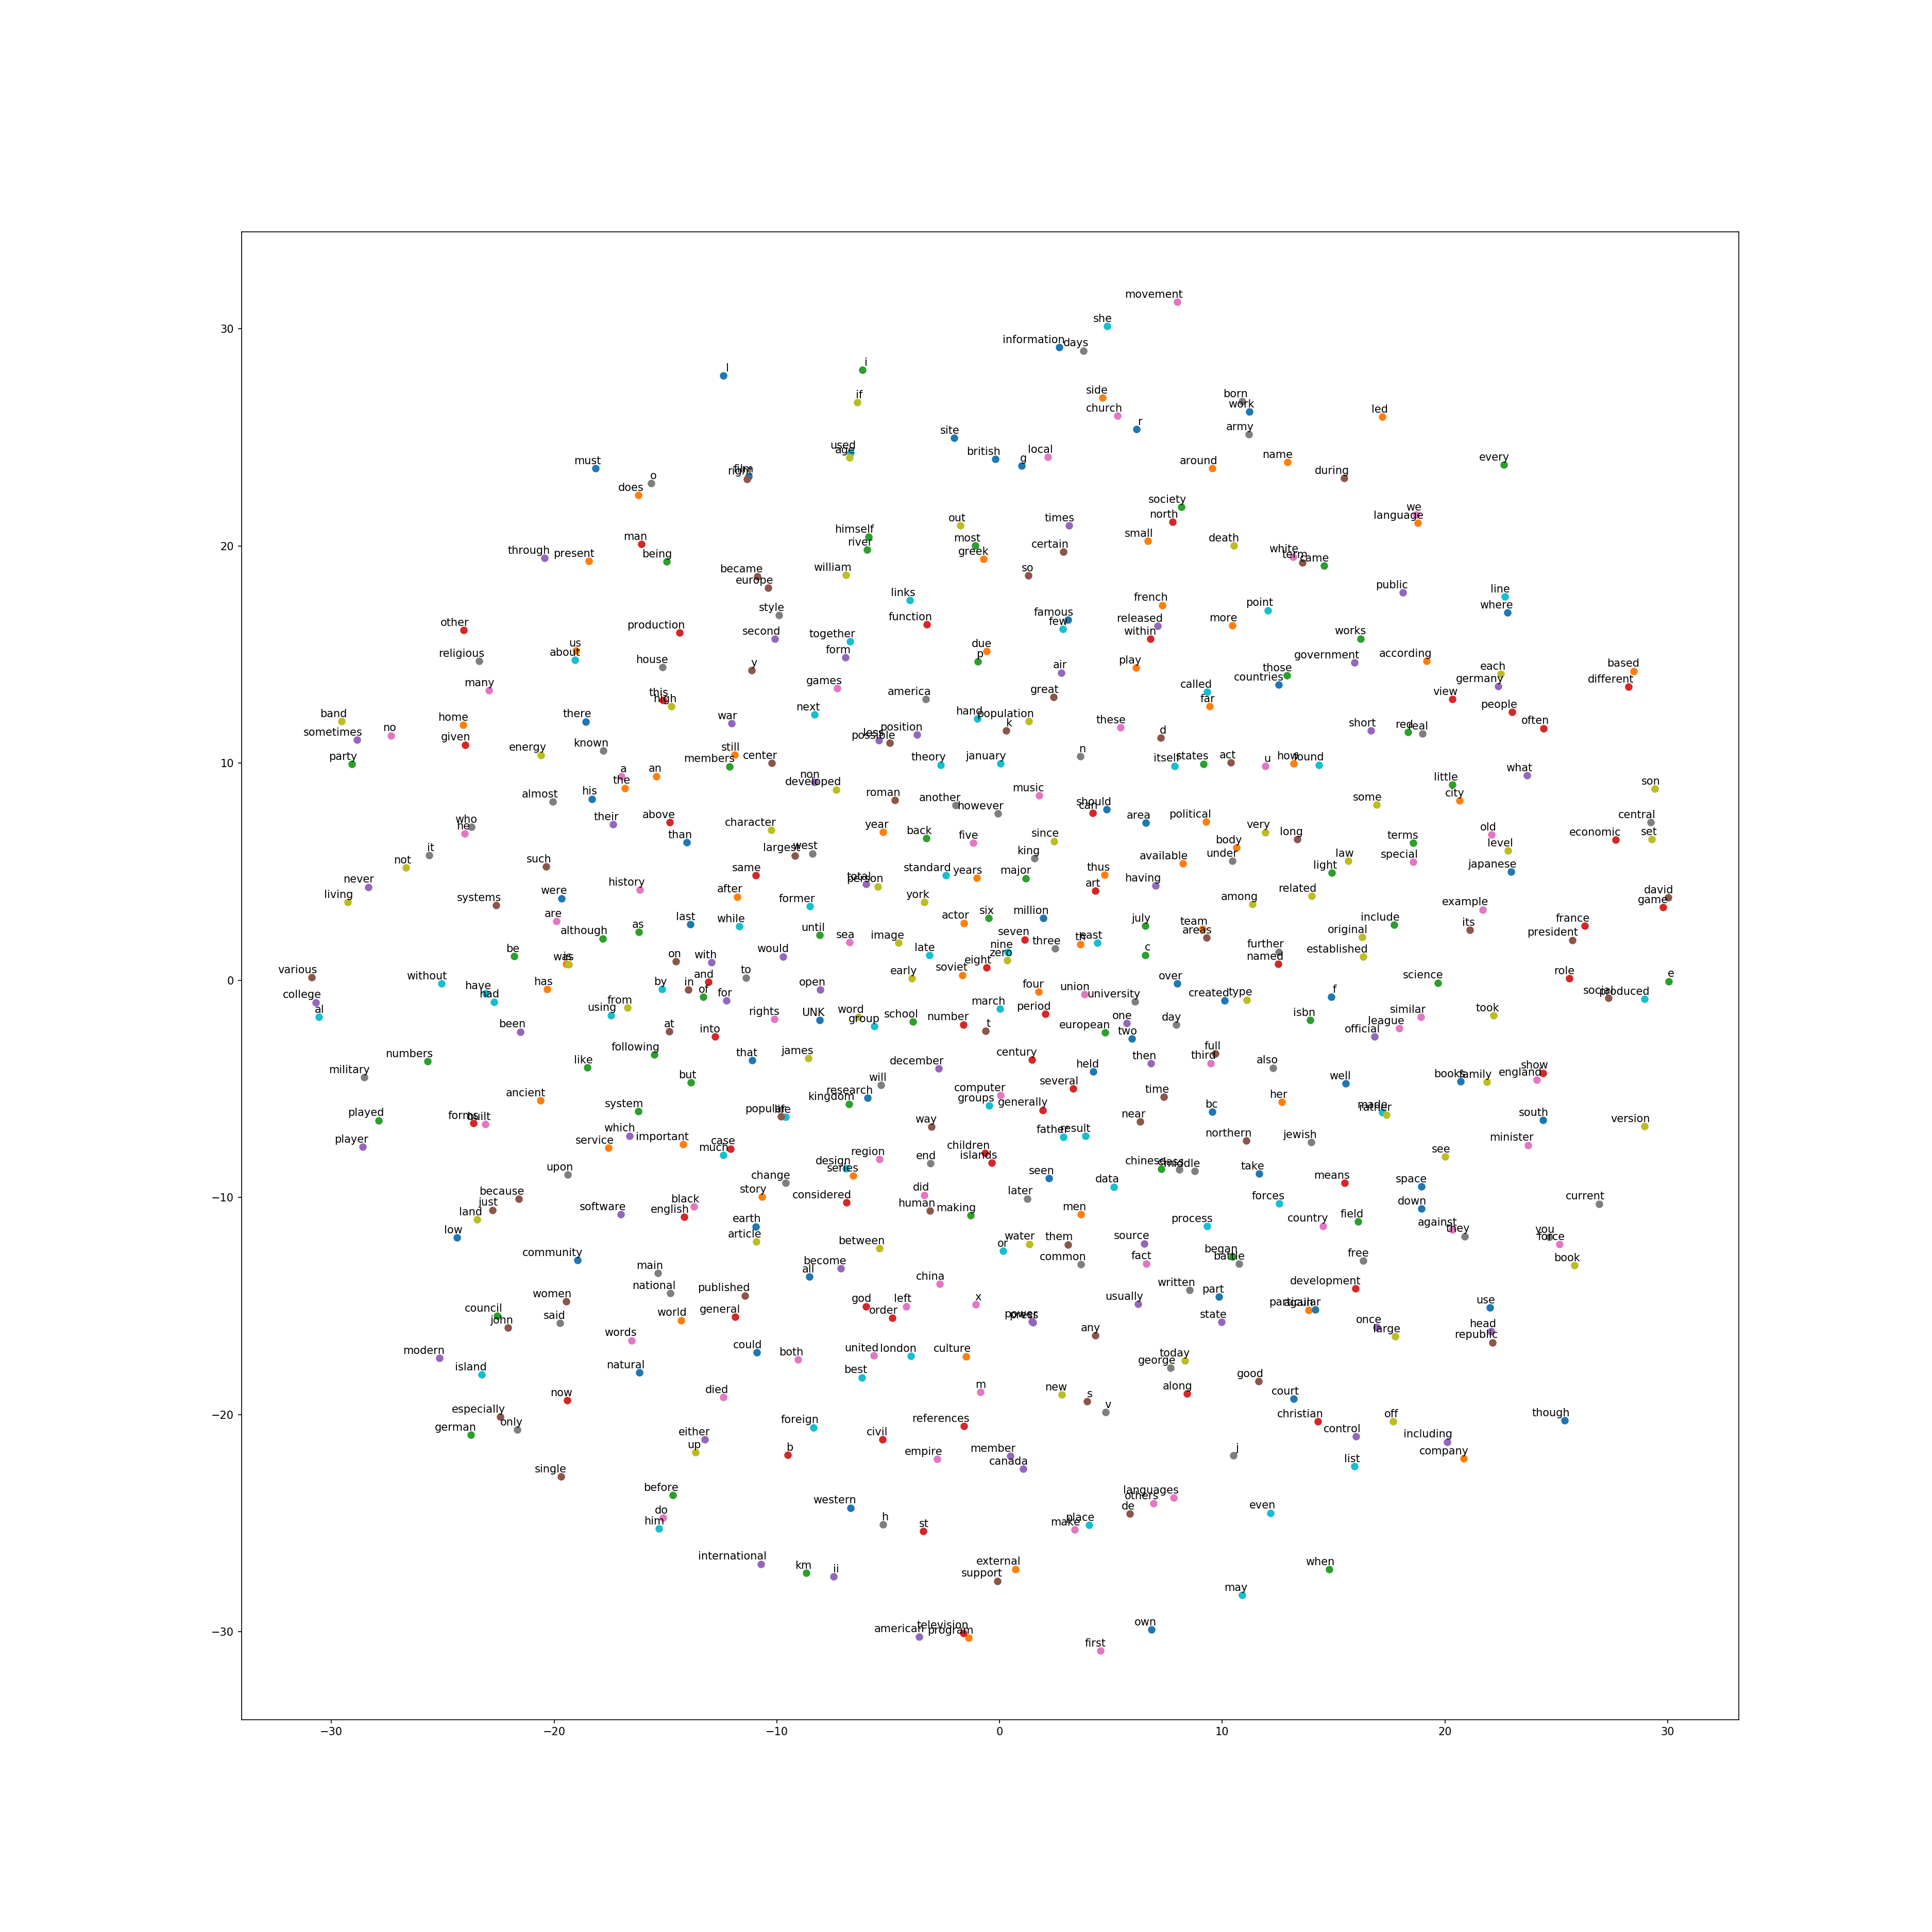

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

A nice example of word vectorization done by some researchers at Warsaw University: [Word2Vec](https://lamyiowce.github.io/word2viz/).

## Negative sampling

It is a simpler implementation of word2vec. It is faster as it takes only a few terms in each iteration for training insted of the whole dataset as in previous example. This is why it's called negative sampling.

First of all, we define helper methods that are used later.

In [4]:
def zeros(*dims):
    return np.zeros(shape=tuple(dims), dtype=np.float32)

def ones(*dims):
    return np.ones(shape=tuple(dims), dtype=np.float32)

def rand(*dims):
    return np.random.rand(*dims).astype(np.float32)

def randn(*dims):
    return np.random.randn(*dims).astype(np.float32)

def sigmoid(batch, stochastic=False):
    return  1.0 / (1.0 + np.exp(-batch))

def as_matrix(vector):
    return np.reshape(vector, (-1, 1))

We need to load the data again.

In [5]:
import pickle
import gzip

with gzip.open("datasets/text8.dat.gz", "rb") as f:
    train_dict, train_set, train_tokens = pickle.load(f)

train_set = np.random.permutation(train_set)

Below we set a few configuration parameters.

In [6]:
from collections import namedtuple
Config = namedtuple("Config", ["dict_size", "vect_size", "neg_samples", "updates", "learning_rate", 
                               "learning_rate_decay", "decay_period", "log_period"])
conf = Config(
    dict_size=len(train_dict),
    vect_size=100,
    neg_samples=10,
    updates=5000000,
    learning_rate=0.1,
    learning_rate_decay=0.995,
    decay_period=10000,
    log_period=10000)

### Exercise 1: Implement the word2vec using negative sampling

In order to train distributed word representations, first:
 - calculate gradient of the cost function with respect to the `word_vector` and store in `word_grad`: $-positive * context vector + \sum (matrix(negative) * negative vector)$.
 - calculate gradient of the cost function with respect to the `context_vect` and store in `context_grad` as following: $-(1.0 - S(positive score)) * word vector$,
 - calculate gradient of the cost function with respect to the sampled `negative_vects` and store in neg_context_grad as following $matrix(S(negative score))*matrix(word vector)$

In [7]:
def neg_sample(conf, train_set, train_tokens): # implemented
    Vp = randn(conf.dict_size, conf.vect_size)
    Vo = randn(conf.dict_size, conf.vect_size)

    J = 0.0
    learning_rate = conf.learning_rate
    for i in range(conf.updates):
        idx = i % len(train_set)

        word    = train_set[idx, 0]
        context = train_set[idx, 1]
        
        neg_context = np.random.randint(0, len(train_tokens), conf.neg_samples)
        neg_context = train_tokens[neg_context]

        word_vect = Vp[word, :]              # word vector
        context_vect = Vo[context, :];       # context wector
        negative_vects = Vo[neg_context, :]  # sampled negative vectors
        
        # Cost and gradient calculation starts here
        score_pos = word_vect @ context_vect.T
        score_neg = word_vect @ negative_vects.T

        J -= np.log(sigmoid(score_pos)) + np.sum(np.log(sigmoid(-score_neg)))
        if (i + 1) % conf.log_period == 0:
            print('Update {0}\tcost: {1:>2.2f}'.format(i + 1, J / conf.log_period))
            final_cost = J / conf.log_period
            J = 0.0

        pos_g = 1.0 - sigmoid(score_pos)
        neg_g = sigmoid(score_neg)

        word_grad = # your code goes here
        context_grad = # your code goes here
        neg_context_grad = # your code goes here
        
        Vp[word, :] -= learning_rate * word_grad
        Vo[context, :] -= learning_rate * context_grad
        Vo[neg_context, :] -= learning_rate * neg_context_grad

        if i % conf.decay_period == 0:
            learning_rate = learning_rate * conf.learning_rate_decay

    return Vp, Vo, final_cost

Next do the training:

In [8]:
Vp, Vo, J = neg_sample(conf, train_set, train_tokens)

Update 10000	cost: 36.44
Update 20000	cost: 28.52
Update 30000	cost: 23.34
Update 40000	cost: 19.56
Update 50000	cost: 17.08
Update 60000	cost: 15.57
Update 70000	cost: 14.36
Update 80000	cost: 13.17
Update 90000	cost: 12.30
Update 100000	cost: 11.45
Update 110000	cost: 11.01
Update 120000	cost: 10.61
Update 130000	cost: 10.09
Update 140000	cost: 9.81
Update 150000	cost: 9.30
Update 160000	cost: 9.18
Update 170000	cost: 8.84
Update 180000	cost: 8.58
Update 190000	cost: 8.27
Update 200000	cost: 8.20
Update 210000	cost: 8.16
Update 220000	cost: 7.82
Update 230000	cost: 7.66
Update 240000	cost: 7.58
Update 250000	cost: 7.41
Update 260000	cost: 7.18
Update 270000	cost: 7.28
Update 280000	cost: 7.02
Update 290000	cost: 6.98
Update 300000	cost: 6.87
Update 310000	cost: 6.78
Update 320000	cost: 6.77
Update 330000	cost: 6.71
Update 340000	cost: 6.56
Update 350000	cost: 6.46
Update 360000	cost: 6.46
Update 370000	cost: 6.36
Update 380000	cost: 6.32
Update 390000	cost: 6.24
Update 400000	cost: 6

Update 3200000	cost: 3.61
Update 3210000	cost: 3.62
Update 3220000	cost: 3.61
Update 3230000	cost: 3.59
Update 3240000	cost: 3.61
Update 3250000	cost: 3.63
Update 3260000	cost: 3.57
Update 3270000	cost: 3.61
Update 3280000	cost: 3.59
Update 3290000	cost: 3.59
Update 3300000	cost: 3.58
Update 3310000	cost: 3.58
Update 3320000	cost: 3.60
Update 3330000	cost: 3.58
Update 3340000	cost: 3.59
Update 3350000	cost: 3.59
Update 3360000	cost: 3.58
Update 3370000	cost: 3.60
Update 3380000	cost: 3.60
Update 3390000	cost: 3.60
Update 3400000	cost: 3.63
Update 3410000	cost: 3.56
Update 3420000	cost: 3.57
Update 3430000	cost: 3.59
Update 3440000	cost: 3.57
Update 3450000	cost: 3.58
Update 3460000	cost: 3.55
Update 3470000	cost: 3.57
Update 3480000	cost: 3.57
Update 3490000	cost: 3.59
Update 3500000	cost: 3.58
Update 3510000	cost: 3.56
Update 3520000	cost: 3.61
Update 3530000	cost: 3.56
Update 3540000	cost: 3.56
Update 3550000	cost: 3.53
Update 3560000	cost: 3.58
Update 3570000	cost: 3.52
Update 35800

Check for the similarity now:

In [9]:
def lookup_word_idx(word, word_dict):
    try:
        return np.argwhere(np.array(word_dict) == word)[0][0]
    except:
        raise Exception("No such word in dict: {}".format(word))

def similar_words(embeddings, word, word_dict, hits):
    word_idx = lookup_word_idx(word, word_dict)
    similarity_scores = embeddings @ embeddings[word_idx]
    similar_word_idxs = np.argsort(-similarity_scores)    
    return [word_dict[i] for i in similar_word_idxs[:hits]]

In [10]:
print('\n\nTraining cost: {0:>2.2f}\n\n'.format(J))

sample_words = ['zero', 'computer', 'cars', 'home', 'album']

Vp_norm = Vp / as_matrix(np.linalg.norm(Vp , axis=1))
for w in sample_words:
    similar = similar_words(Vp_norm, w, train_dict, 10)
    print('Words similar to {}: {}'.format(w, ", ".join(similar)))



Training cost: 3.44


Words similar to zero: zero, three, four, five, eight
Words similar to computer: computer, software, digital, technology, program
Words similar to cars: cars, fast, lines, device, used
Words similar to home: home, club, city, building, road
Words similar to album: album, band, song, songs, release


#### References

[1] Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. 